In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlin

In [2]:
from scipy import ndimage
from scipy.ndimage.filters import convolve
import math

In [3]:
img = cv2.imread('messi.png',0)

In [4]:
#convert the image to grayscale pixel by pixel
def getGrayScaledPixel(rgbPixel):
    return 0.2126 * rgbPixel[0] + 0.7152 * rgbPixel[1] + 0.0722 * rgbPixel[2]

In [5]:
#deriving the gaussian filter (5x5)
def gaussian_filter(size, sigma=1.4):
  size = int(size)//2
  x,y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1/(2 * np.pi * sigma **2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

In [6]:
#applying sobel filter to the image
def sobel_filters(img):

        M,N = img.shape
        I = np.zeros((M,N), dtype=np.int32)
        G = np.zeros((M,N), dtype=np.int32)
        #Sobel Filter applied on the X-axis
        Kx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #Sobel Filter applied on the Y-axis
        Ky = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

        Ix = ndimage.filters.convolve(img, Kx)

        Iy = ndimage.filters.convolve(img, Ky)

        #for i in range(0,M-1):
         #for j in range(0,N-1):
          #I[i,j] = (Ix[i,j]*Ix[i,j]) + (Iy[i,j]*Iy[i,j])
          #G[i,j] = math.sqrt(I[i,j])

        G = np.hypot(Ix, Iy)
        #G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

In [7]:
def non_supression(img,D):
  M,N=img.shape
  Z = np.zeros((M,N), dtype=np.int32)
  angle = D*180/np.pi
  angle[angle<0]+=180

  for i in range(0,M-1):
    for j in range(0,N-1):
      q=255
      r=255
      if((0<= angle[i,j] <22.5) or (157.5<=angle[i,j]<=180)):
        q = angle[i,j+1]
        r= angle[i,j-1]
      elif(22.5<=angle[i,j]<=67.5):
        q = angle[i+1,j-1]
        r= angle[i-1,j+1]
      elif (67.5 <= angle[i,j] < 112.5):
        q = img[i+1, j]
        r = img[i-1, j]
      
      elif (112.5 <= angle[i,j] < 157.5):
        q = img[i-1, j-1]
        r = img[i+1, j+1]
      if (img[i,j] >= q) and (img[i,j] >= r):
        Z[i,j] = img[i,j]
      else:
        Z[i,j] = 0

  return Z

In [8]:
  def threshold(img, highThreshold=0.15, lowThreshold=0.05, strong_pixel=255, weak_pixel=75):

      highThreshold = 190
      
      lowThreshold = 50
      M, N = img.shape
      res = np.zeros((M,N), dtype=np.int32)

      for i in range(0,M-1):
        for j in range(0,N-1):
          if(img[i,j]<lowThreshold):
            res[i,j]=0
          elif(lowThreshold<=img[i,j]<highThreshold):
            res[i,j] = weak_pixel
          elif(img[i,j]>highThreshold):
            res[i,j]=strong_pixel

      return (res)

In [9]:
def hysteresis(img,strong_pixel=255, weak_pixel=75):
  M,N = img.shape
  canny = np.zeros((M,N), dtype = np.int32)

  weak = weak_pixel
  strong = strong_pixel
  for i in range(0,M-1):
    for j in range(0,N-1):
      if(img[i,j]==weak):
        if((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
          canny[i,j]=strong
        else:
          canny[i,j]=0
  
  canny = canny / canny.max() * 255
  return(canny)

In [10]:
def hough(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="blue")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()

In [11]:
pixel = np.array(img)
if len(pixel.shape) == 3:
        output = convertToGrayScale(pixel)
else:
        output = pixel.copy()

In [12]:
F = gaussian_filter(5)

In [13]:
gaussian = ndimage.filters.convolve(output, F)

In [14]:
sobel, theta= sobel_filters(output)

In [15]:
sobel = sobel.astype(int)

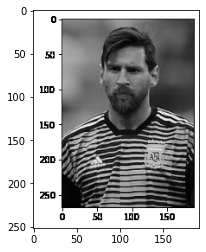

In [16]:
arr = np.asarray(img)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [17]:
non_supressed=non_supression(sobel,theta)

In [18]:
thresh = threshold(non_supressed)

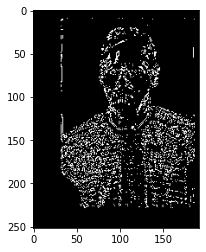

In [19]:
final_image = hysteresis(thresh)
arr = np.asarray(final_image)
plt.imshow(arr,cmap='gray',vmin=0, vmax=255)
plt.show()

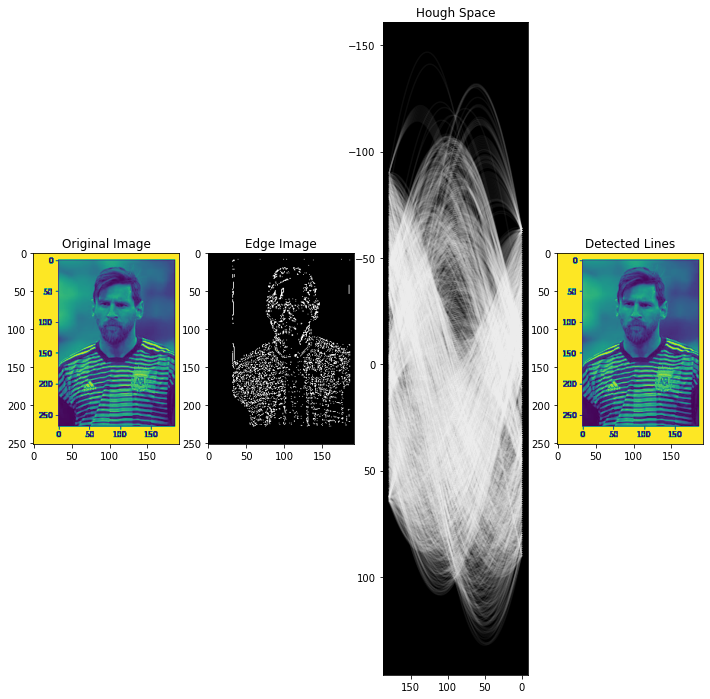

In [21]:
hough(img, final_image)